<a href="https://colab.research.google.com/github/PIYUSH9090/End-to-end-deep-learning/blob/main/Deep_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/Tony607/Industrial-Defect-Inspection-segmentation
%cd /content/Industrial-Defect-Inspection-segmentation

Cloning into 'Industrial-Defect-Inspection-segmentation'...
remote: Enumerating objects: 35, done.
remote: Counting objects: 100% (35/35), done.
remote: Compressing objects: 100% (32/32), done.
remote: Total 35 (delta 9), reused 20 (delta 1), pack-reused 0
Unpacking objects: 100% (35/35), done.
/content/Industrial-Defect-Inspection-segmentation


In [43]:
from IPython.display import Image
%matplotlib inline

In [3]:
!wget https://resources.mpi-inf.mpg.de/conference/dagm/2007/Class1_def.zip
!unzip -q Class1_def.zip -d .

--2020-11-07 15:03:28--  https://resources.mpi-inf.mpg.de/conference/dagm/2007/Class1_def.zip
Resolving resources.mpi-inf.mpg.de (resources.mpi-inf.mpg.de)... 139.19.206.46
Connecting to resources.mpi-inf.mpg.de (resources.mpi-inf.mpg.de)|139.19.206.46|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://resources.mpi-inf.mpg.de/conferences/dagm/2007/Class1_def.zip [following]
--2020-11-07 15:03:28--  https://resources.mpi-inf.mpg.de/conferences/dagm/2007/Class1_def.zip
Reusing existing connection to resources.mpi-inf.mpg.de:443.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://conferences.mpi-inf.mpg.de/dagm/2007/Class1_def.zip [following]
--2020-11-07 15:03:28--  https://conferences.mpi-inf.mpg.de/dagm/2007/Class1_def.zip
Resolving conferences.mpi-inf.mpg.de (conferences.mpi-inf.mpg.de)... 139.19.206.169
Connecting to conferences.mpi-inf.mpg.de (conferences.mpi-inf.mpg.de)|139.19.206.169|:443... connected.
H

In [45]:
import matplotlib.pyplot as plt
%matplotlib inline
import os

In [46]:
data_dir = "./Class1_def"

In [47]:
!pip install xmltodict

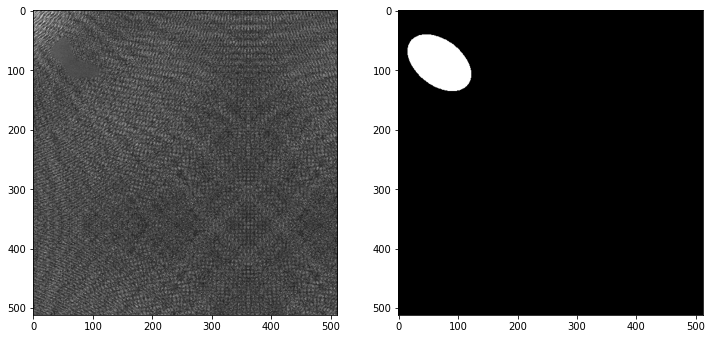

In [48]:
from coslib import plot_ellipse_seg_test

plot_ellipse_seg_test(os.path.join(data_dir, "1.png"))

In [51]:
from coslib import load_images_masks

In [50]:
X, y = load_images_masks(data_dir, img_type='png', img_format='gray', resize=(512, 512), ellipse=True)

In [52]:
X.shape

(150, 512, 512, 1)

In [53]:
y.shape

(150, 512, 512, 1)

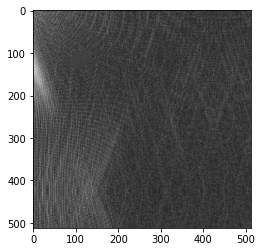

In [54]:
plt.imshow(X[0,:,:,0], cmap='gray')

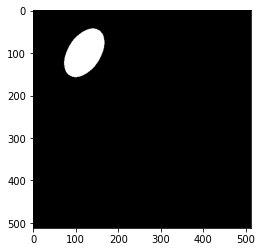

In [55]:
plt.imshow(y[0,:,:,0], cmap='gray')

In [56]:
import sklearn
from sklearn.model_selection import train_test_split

In [57]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [58]:
X_train.shape

(105, 512, 512, 1)

In [59]:
X_test.shape

(45, 512, 512, 1)

In [60]:
img_rows = 512
img_cols = 512

In [61]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Lambda, Conv2DTranspose, concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras import backend as K
from scipy.ndimage.measurements import label
import time

In [62]:
# Defining a small Unet
# Smaller Unet defined so it fits in memory


def get_small_unet():
    inputs = Input((img_rows, img_cols, 1))
    inputs_norm = Lambda(lambda x: x/127.5 - 1.)
    conv1 = Conv2D(16, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(16, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(32, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv5)

    up6 = concatenate([Conv2DTranspose(64, kernel_size=(
        2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
    conv6 = Conv2D(128, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv6)

    up7 = concatenate([Conv2DTranspose(32, kernel_size=(
        2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
    conv7 = Conv2D(64, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv7)

    up8 = concatenate([Conv2DTranspose(16, kernel_size=(
        2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    conv8 = Conv2D(32, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv8)

    up9 = concatenate([Conv2DTranspose(8, kernel_size=(
        2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    conv9 = Conv2D(16, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(16, (3, 3), activation='relu', padding='same')(conv9)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

    model = Model(inputs=inputs, outputs=conv10)

    return model

In [63]:
model = get_small_unet()

In [64]:
def smooth_dice_coeff(smooth=1.):

    smooth = float(smooth)

    # IOU or dice coeff calculation
    def IOU_calc(y_true, y_pred):
            y_true_f = K.flatten(y_true)
            y_pred_f = K.flatten(y_pred)
            intersection = K.sum(y_true_f * y_pred_f)

            return 2*(intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

    def IOU_calc_loss(y_true, y_pred):
        return -IOU_calc(y_true, y_pred)
    return IOU_calc, IOU_calc_loss

IOU_calc, IOU_calc_loss = smooth_dice_coeff(0.00001)

In [65]:
model.compile(optimizer=Adam(lr=1e-4), loss=IOU_calc_loss, metrics=[IOU_calc])

In [66]:
history = model.fit(X_train, y_train, batch_size=10, epochs=50, verbose=1, validation_split=0.1)

Epoch 1/50
10/10 [==============================] - 3s 305ms/step - loss: -0.0722 - IOU_calc: 0.0732 - val_loss: -0.0847 - val_IOU_calc: 0.0904
Epoch 2/50
10/10 [==============================] - 3s 268ms/step - loss: -0.0809 - IOU_calc: 0.0818 - val_loss: -0.0923 - val_IOU_calc: 0.0993
Epoch 3/50
10/10 [==============================] - 3s 270ms/step - loss: -0.0915 - IOU_calc: 0.0914 - val_loss: -0.1076 - val_IOU_calc: 0.1165
Epoch 4/50
10/10 [==============================] - 3s 267ms/step - loss: -0.1137 - IOU_calc: 0.1151 - val_loss: -0.1424 - val_IOU_calc: 0.1581
Epoch 5/50
10/10 [==============================] - 3s 271ms/step - loss: -0.1651 - IOU_calc: 0.1682 - val_loss: -0.2343 - val_IOU_calc: 0.2634
Epoch 6/50
10/10 [==============================] - 3s 273ms/step - loss: -0.2754 - IOU_calc: 0.2784 - val_loss: -0.2923 - val_IOU_calc: 0.3087
Epoch 7/50
10/10 [==============================] - 3s 273ms/step - loss: -0.3261 - IOU_calc: 0.3255 - val_loss: -0.3643 - val_IOU_calc:

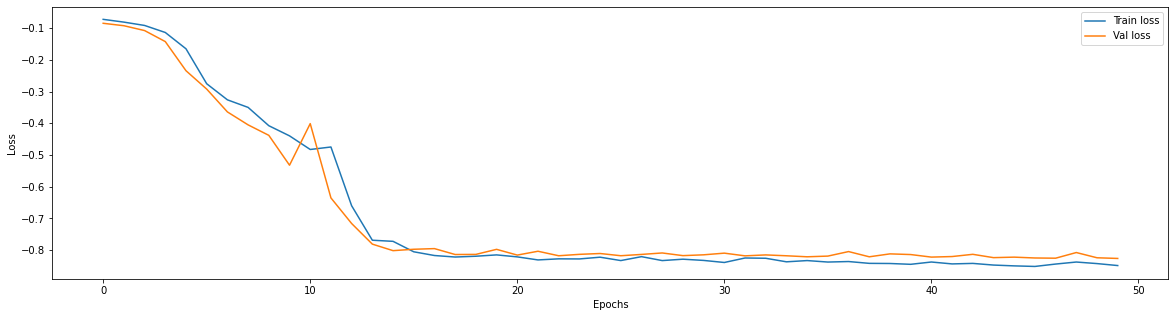

In [68]:
plt.figure(figsize=(20, 5))
plt.plot(model.history.history['loss'], label='Train loss')
plt.plot(model.history.history['val_loss'], label='Val loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

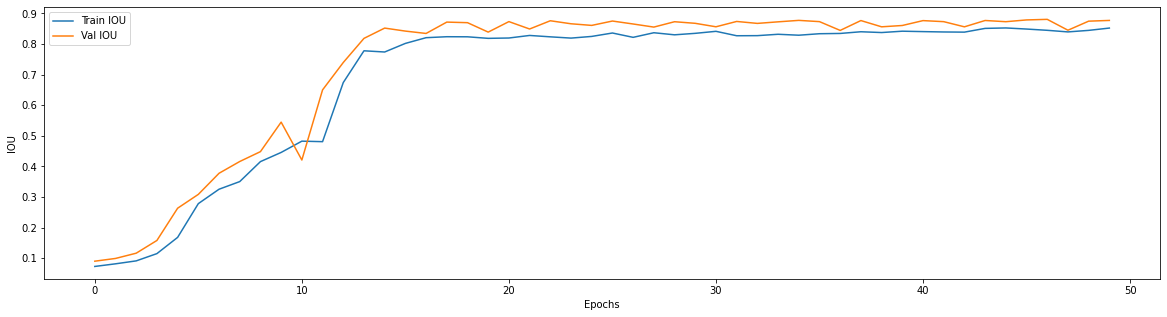

In [69]:
plt.figure(figsize=(20, 5))
plt.plot(model.history.history['IOU_calc'], label='Train IOU')
plt.plot(model.history.history['val_IOU_calc'], label='Val IOU')
plt.xlabel('Epochs')
plt.ylabel('IOU')
plt.legend()

In [70]:
predict = model.predict(X_test)

In [71]:
import numpy as np
import cv2


def predict_evaluation(pred, image, label):
    '''
    '''
    # transform gray image to rgb
    img = np.array(image, np.uint8)
    rgb_img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    # scale pred and mask's pixel range to 0~255
    im_label = np.array(255*label, dtype=np.uint8)
    im_pred = np.array(255*pred, dtype=np.uint8)

    # transform both of them to rgb
    rgb_label = cv2.cvtColor(im_label, cv2.COLOR_GRAY2RGB)
    rgb_pred = cv2.cvtColor(im_pred, cv2.COLOR_GRAY2RGB)

    rgb_label[:, :, 1:3] = 0*rgb_label[:, :, 1:2]
    rgb_pred[:, :, 0] = 0*rgb_pred[:, :, 0]
    rgb_pred[:, :, 2] = 0*rgb_pred[:, :, 2]

    img_pred = cv2.addWeighted(rgb_img, 1, rgb_pred, 0.3, 0)
    img_label = cv2.addWeighted(rgb_img, 1, rgb_label, 0.3, 0)

    plt.figure(figsize=(10, 10))

    plt.subplot(1, 3, 1)
    plt.imshow(rgb_img)
    plt.title('Original image')
    plt.axis('off')
    plt.subplot(1, 3, 2)
    plt.imshow(img_pred)
    plt.title('Prediction')
    plt.axis('off')
    plt.subplot(1, 3, 3)
    plt.imshow(img_label)
    plt.title('Ground truth')
    plt.axis('off')

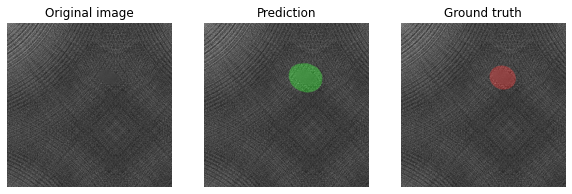

In [72]:
predict_evaluation(predict[0,:,:,0], X_test[0,:,:,0], y_test[0,:,:,0])

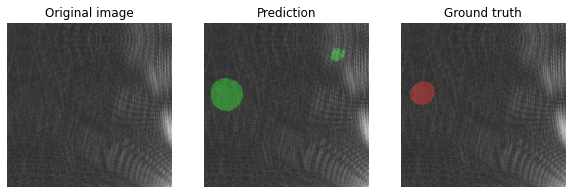

In [73]:
predict_evaluation(predict[1,:,:,0], X_test[1,:,:,0], y_test[1,:,:,0])

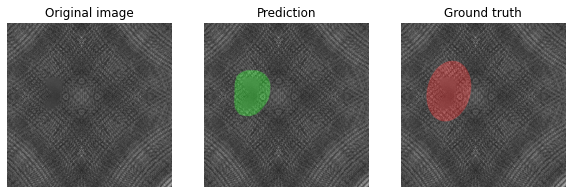

In [74]:
predict_evaluation(predict[2,:,:,0], X_test[2,:,:,0], y_test[2,:,:,0])

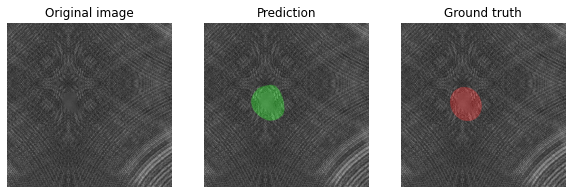

In [75]:
predict_evaluation(predict[3,:,:,0], X_test[3,:,:,0], y_test[3,:,:,0])

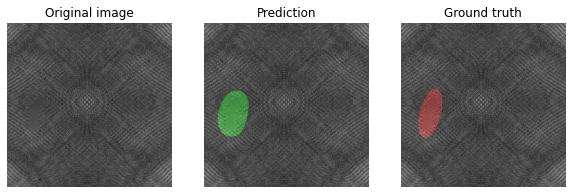

In [76]:
predict_evaluation(predict[4,:,:,0], X_test[4,:,:,0], y_test[4,:,:,0])

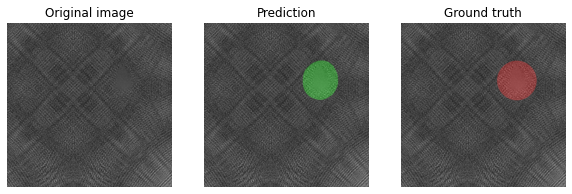

In [77]:
predict_evaluation(predict[5,:,:,0], X_test[5,:,:,0], y_test[5,:,:,0])

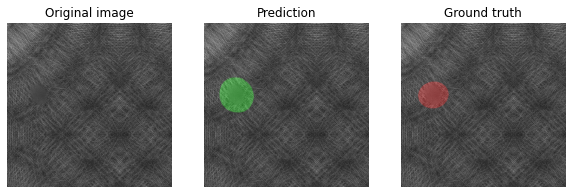

In [78]:
predict_evaluation(predict[6,:,:,0], X_test[6,:,:,0], y_test[6,:,:,0])

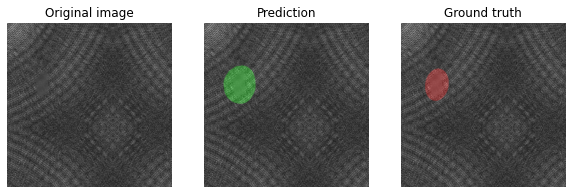

In [79]:
predict_evaluation(predict[7,:,:,0], X_test[7,:,:,0], y_test[7,:,:,0])

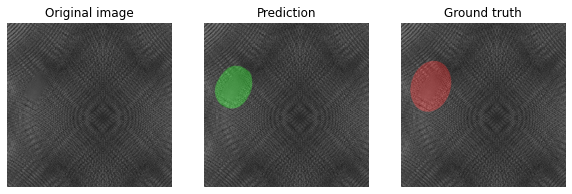

In [80]:
predict_evaluation(predict[8,:,:,0], X_test[8,:,:,0], y_test[8,:,:,0])

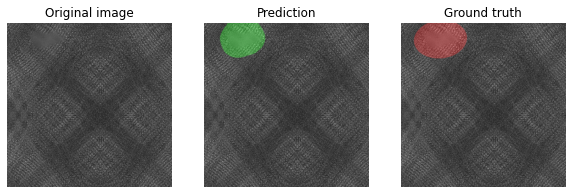

In [81]:
predict_evaluation(predict[9,:,:,0], X_test[9,:,:,0], y_test[9,:,:,0])

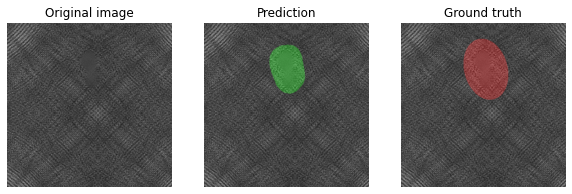

In [82]:
predict_evaluation(predict[10,:,:,0], X_test[10,:,:,0], y_test[10,:,:,0])